In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from data_processing import make_classification, fetch_covtype, create_dataset
from MLP import MLP
from rainbow_MLP import rainbow_MLP
from sklearn import preprocessing
from testing import test
from torch.utils.data import DataLoader, TensorDataset
from training import train
from utils import check_normalisation, plot_results_2D, check_alignement

## Données

In [2]:
train_dataloaders = []
val_dataloaders = []
test_dataloaders = []

len_train_datas = []
len_test_datas = []

dimensions = [5]

for d in dimensions:
    train_data = np.load('data/eldan-smooth-train-'+str(d)+'-data.npy')
    len_train_datas.append(train_data.shape[0])
    train_label = np.load('data/eldan-smooth-train-'+str(d)+'-label.npy')

    train_label[np.where(train_label>=0.5)[0]] = 1
    train_label[np.where((train_label<0.5) & (train_label>-0.5))[0]] = 0
    train_label[np.where(train_label<=-0.5)[0]] = 2

    val_data = train_data[int(0.8*train_data.shape[0]):]
    val_label = train_label[int(0.8*train_label.shape[0]):]

    train_data = train_data[:int(0.8*train_data.shape[0])]
    train_label = train_label[:int(0.8*train_label.shape[0])]

    test_data = np.load('data/eldan-smooth-test-'+str(d)+'-data.npy')
    len_test_datas.append(test_data.shape[0])
    test_label = np.load('data/eldan-smooth-test-'+str(d)+'-label.npy')

    test_label[np.where(test_label>=0.5)[0]] = 1
    test_label[np.where((test_label<0.5) & (test_label>-0.5))[0]] = 0
    test_label[np.where(test_label<=-0.5)[0]] = 2

    train_data = TensorDataset(torch.from_numpy(np.array(train_data)).float(), 
                                torch.from_numpy(np.array(train_label)).long())
    val_data = TensorDataset(torch.from_numpy(np.array(val_data)).float(), 
                                torch.from_numpy(np.array(val_label)).long())
    test_data = TensorDataset(torch.from_numpy(np.array(test_data)).float(), 
                                torch.from_numpy(np.array(test_label)).long())

    train_dataloaders.append(DataLoader(train_data, batch_size=64, shuffle=True))
    val_dataloaders.append(DataLoader(val_data, batch_size=64, shuffle=True))
    test_dataloaders.append(DataLoader(test_data, batch_size=64, shuffle=True))

## Entraînements

On entraîne un MLP à 1CC, à 2CCs et un Special_Rainbow pour des largeurs de couches variables. Les modèles ont tous (env.) le même nombre total de paramètres. Pour chaque largeur, on réalise 10 entraînements.

In [3]:
# Choix des largeurs à tester

N_1CC = [10, 50, 100, 500, 1000]

In [4]:
print(torch.cuda.is_available())
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
print("[INFO] training using {}.".format(DEVICE))

def routine(model, id_dim):
    model.to(DEVICE)
    train(model, train_dataloaders[id_dim], val_dataloaders[id_dim], 10, len_train_datas[id_dim], DEVICE)
    test_acc = test(model, test_dataloaders[id_dim], len_test_datas[id_dim], DEVICE, text = False)
    return test_acc

results = pd.DataFrame(columns=['Dim', 'Model', 'Nb_params', 'Run', 'Accuracy'])

for id_dim, dim in enumerate(dimensions):
    print("Dimension : ", dim)
    
    f = 3+dim
    N_2CCs = [int((np.sqrt(f**2+4*f*n)-f)/2) for n in N_1CC]
    N_SR = [int(f/(6+dim)*n) for n in N_1CC]
    
    for id_largeur, largeur in enumerate(N_1CC):
        print("Largeur : ", largeur)
        for run in range(10):
            print("Run : ", run)
            # MLP 1CC
            MLP_1CC = MLP(dim, [N_1CC[id_largeur], 3], batch_norm = True)
            test_acc_MLP_1CC = routine(MLP_1CC, id_dim)
            results = pd.concat([results, pd.DataFrame([[dim, 'MLP_1CC', f*largeur, run, test_acc_MLP_1CC]],
                                        columns=results.columns)], ignore_index=True)

            # MLP 2CCs
            MLP_2CCs = MLP(dim, [N_2CCs[id_largeur], N_2CCs[id_largeur], 3], batch_norm = True)
            test_acc_MLP_2CCs = routine(MLP_2CCs, id_dim)
            results = pd.concat([results, pd.DataFrame([[dim, 'MLP_2CCs', f*largeur, run, test_acc_MLP_2CCs]],
                                        columns=results.columns)], ignore_index=True)
            
            # Special Rainbow
            Special_Rainbow = MLP(N_SR[id_largeur], [3], no_hidden_layer=True,
                                  N_1=N_SR[id_largeur], N_2=N_SR[id_largeur], special_dim=dim, device=DEVICE)
            test_acc_Special_Rainbow = routine(Special_Rainbow, id_dim)
            results = pd.concat([results, pd.DataFrame([[dim, 'Special_Rainbow', f*largeur, run,
                                        test_acc_Special_Rainbow]], columns=results.columns)], ignore_index=True)

results.to_csv('results.csv')

True
[INFO] training using cuda:1.
Dimension :  5
Largeur :  10
Run :  0
Run :  1
Run :  2
Run :  3
Run :  4
Run :  5
Run :  6
Run :  7
Run :  8
Run :  9
Largeur :  50
Run :  0
Run :  1
Run :  2
Run :  3
Run :  4
Run :  5
Run :  6
Run :  7
Run :  8
Run :  9
Largeur :  100
Run :  0
Run :  1
Run :  2
Run :  3
Run :  4
Run :  5
Run :  6
Run :  7
Run :  8
Run :  9
Largeur :  500
Run :  0
Run :  1
Run :  2
Run :  3
Run :  4
Run :  5
Run :  6
Run :  7
Run :  8
Run :  9
Largeur :  1000
Run :  0
Run :  1
Run :  2
Run :  3
Run :  4
Run :  5
Run :  6
Run :  7
Run :  8
Run :  9


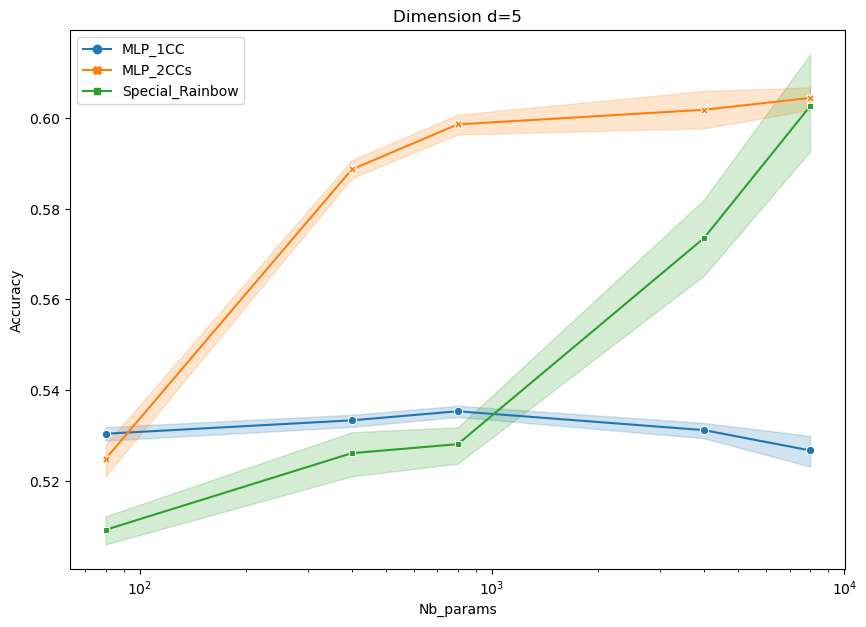

In [5]:
# Affichage des résultats
for dim in dimensions:
    dim_results = results.query('Dim=='+str(dim))
    plt.figure(figsize=(10,7))
    sns.lineplot(data=dim_results, x="Nb_params", y="Accuracy", hue="Model", style="Model", markers=True, dashes=False)
    plt.title("Dimension d="+str(dim))
    plt.xscale('log')
    plt.legend(loc='best')
    plt.savefig('fig/figure_E&S_'+str(dim)+'_tres.pdf')
    plt.show()
    plt.close()